In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [199]:
# 1) Load data
df = pd.read_csv("titanic (1).csv")
df


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [200]:
# 2) Basic cleaning: drop columns that are clearly not useful for this model
df = df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])

# Encode Sex and Embarked
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])
embarked_dummies = pd.get_dummies(df["Embarked"], prefix="Embarked")
df = pd.concat([df.drop(columns=["Embarked"]), embarked_dummies], axis=1)

# Handle missing Age and Fare with median
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Fare"] = df["Fare"].fillna(df["Fare"].median())

# Target and features
y = df["Survived"].values.reshape(-1, 1)
X = df.drop(columns=["Survived"]).values.astype(float)
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,False,False,True
1,1,1,1,38.0,1,0,71.2833,True,False,False
2,1,3,1,26.0,0,0,7.9250,False,False,True
3,1,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,0,35.0,0,0,8.0500,False,False,True
...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,False,False,True
887,1,1,1,19.0,0,0,30.0000,False,False,True
888,0,3,1,28.0,1,2,23.4500,False,False,True
889,1,1,0,26.0,0,0,30.0000,True,False,False


In [201]:
# 4) Train-test split (80-20) 
np.random.seed(42)
m = X.shape[0]
indices = np.random.permutation(m)
train_size = int(0.8 * m)

train_idx = indices[:train_size]
test_idx = indices[train_size:]

X_train = X[train_idx]
y_train = y[train_idx]
X_test = X[test_idx]
y_test = y[test_idx]

In [202]:
# 5) Standardization (mean 0, std 1) based on train only
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0) + 1e-8  # avoid division by zero

X_train_std = (X_train - X_mean) / X_std
X_test_std = (X_test - X_mean) / X_std

In [203]:
# 5b) PCA from scratch 
def pca(X, n_components):
    # X is already standardized
    cov_matrix = np.cov(X.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    # sort eigenvectors by descending eigenvalues
    idxs = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idxs]
    eigenvectors = eigenvectors[:, idxs]
    # select first n_components
    components = eigenvectors[:, :n_components]
    X_pca = X @ components
    return X_pca, components, eigenvalues
# Choose number of components 
n_components = 3
X_train_pca, components, eigenvalues = pca(X_train_std, n_components)
X_test_pca = X_test_std @ components

In [204]:
# 6) Logistic regression from scratch (with L2 regularization optional)
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def compute_cost(X, y, w, b, lambda_reg=0.0):
    m = X.shape[0]
    z = X @ w + b
    h = sigmoid(z)
    # avoid log(0)
    eps = 1e-12
    cost = (-1 / m) * (y.T @ np.log(h + eps) + (1 - y).T @ np.log(1 - h + eps))
    cost = cost.item()
    # L2 regularization
    cost += (lambda_reg / (2 * m)) * np.sum(w ** 2)
    return cost

def compute_gradients(X, y, w, b, lambda_reg=0.0):
    m = X.shape[0]
    z = X @ w + b
    h = sigmoid(z)
    dw = (1 / m) * (X.T @ (h - y)) + (lambda_reg / m) * w
    db = (1 / m) * np.sum(h - y)
    return dw, db

def gradient_descent(X, y, lr=0.1, num_iters=1000, lambda_reg=0.0):
    n_features = X.shape[1]
    w = np.zeros((n_features, 1))
    b = 0.0
    cost_history = []

    for i in range(num_iters):
        dw, db = compute_gradients(X, y, w, b, lambda_reg)
        w -= lr * dw
        b -= lr * db
        cost = compute_cost(X, y, w, b, lambda_reg)
        cost_history.append(cost)
    return w, b, cost_history
# Run once with large iterations to inspect stagnation
initial_iters = 100
learning_rate = 0.1
lambda_reg = 0.0

w_full, b_full, cost_history_full = gradient_descent(
    X_train_pca, y_train, lr=learning_rate, num_iters=initial_iters, lambda_reg=lambda_reg
)

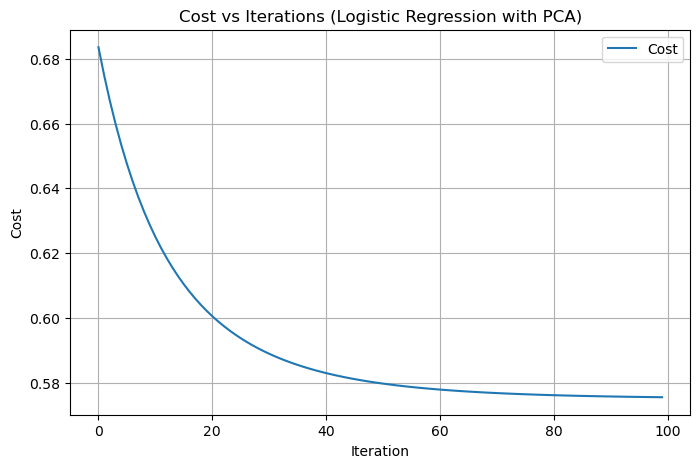

Using iterations: 78


In [205]:
# 9a) Plot cost vs iterations and find stagnation
plt.figure(figsize=(8, 5))
plt.plot(range(len(cost_history_full)), cost_history_full, label="Cost")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost vs Iterations (Logistic Regression with PCA)")
plt.grid(True)
plt.legend()
plt.show()

# Heuristic: find iteration where relative change in cost becomes very small
cost_array = np.array(cost_history_full)
rel_change = np.abs(np.diff(cost_array) / (cost_array[:-1] + 1e-12))
stagnation_threshold = 1e-4
stagnation_iters = np.where(rel_change < stagnation_threshold)[0]
if len(stagnation_iters) > 0:
    optimal_iters = int(stagnation_iters[0] + 1)
else:
    optimal_iters = initial_iters  # fallback

print("Using iterations:", optimal_iters)
# Retrain with optimal number of iterations
w_opt, b_opt, cost_history_opt = gradient_descent(
    X_train_pca, y_train, lr=learning_rate, num_iters=optimal_iters, lambda_reg=lambda_reg
)



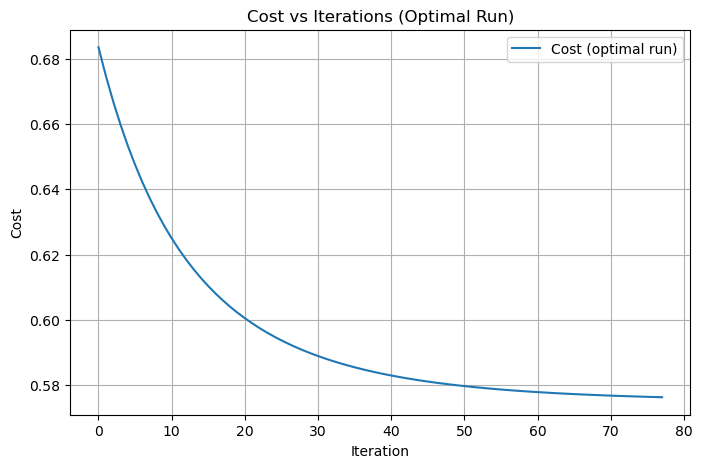

In [206]:
# 9c) Cost history graph (already plotted above, but here plot the optimal run)
plt.figure(figsize=(8, 5))
plt.plot(range(len(cost_history_opt)), cost_history_opt, label="Cost (optimal run)")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost vs Iterations (Optimal Run)")
plt.grid(True)
plt.legend()
plt.show()


In [207]:
# 7) Metrics
def predict_proba(X, w, b):
    return sigmoid(X @ w + b)

def predict(X, w, b, threshold=0.5):
    return (predict_proba(X, w, b) >= threshold).astype(int)

def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def confusion_matrix_manual(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp],
                     [fn, tp]])

def precision_recall_f1(y_true, y_pred):
    cm = confusion_matrix_manual(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp + 1e-12)
    recall = tp / (tp + fn + 1e-12)
    f1 = 2 * precision * recall / (precision + recall + 1e-12)
    return precision, recall, f1

In [208]:
# 8) Train, predict and evaluate (already trained, now evaluate)
y_train_pred = predict(X_train_pca, w_opt, b_opt)
y_test_pred = predict(X_test_pca, w_opt, b_opt)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_precision, train_recall, train_f1 = precision_recall_f1(y_train, y_train_pred)
test_precision, test_recall, test_f1 = precision_recall_f1(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Train Precision: {train_precision:.4f}, \nTrain Recall: {train_recall:.4f}, \nTrain F1: {train_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}, \nTest Recall: {test_recall:.4f}, \nTest F1: {test_f1:.4f}")

Train Accuracy: 0.7051
Train Precision: 0.6667, 
Train Recall: 0.4838, 
Train F1: 0.5607
Test Accuracy: 0.6816
Test Precision: 0.5909, 
Test Recall: 0.4000, 
Test F1: 0.4771


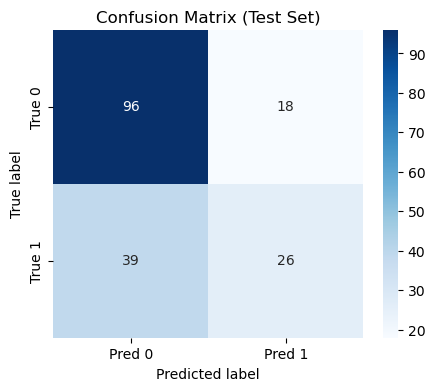

Confusion matrix (Train):
[[368  67]
 [143 134]]


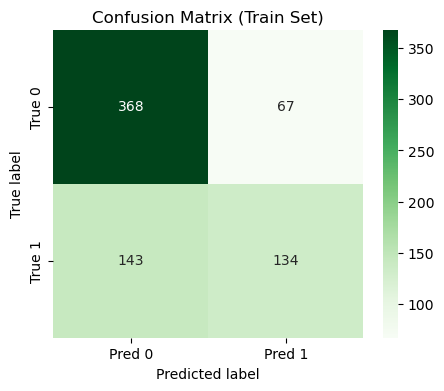

In [ ]:
# 9b) Confusion matrix visualization 
cm_test = confusion_matrix_manual(y_test, y_test_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix (Test Set)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()
# Predictions on TRAIN set
y_train_pred = predict(X_train_pca, w_opt, b_opt)

# Confusion matrix for TRAIN set
cm_train = confusion_matrix_manual(y_train, y_train_pred)
print("Confusion matrix (Train):")
print(cm_train)

# Optional: visualize with heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm_train,
            annot=True,
            fmt="d",
            cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix (Train Set)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


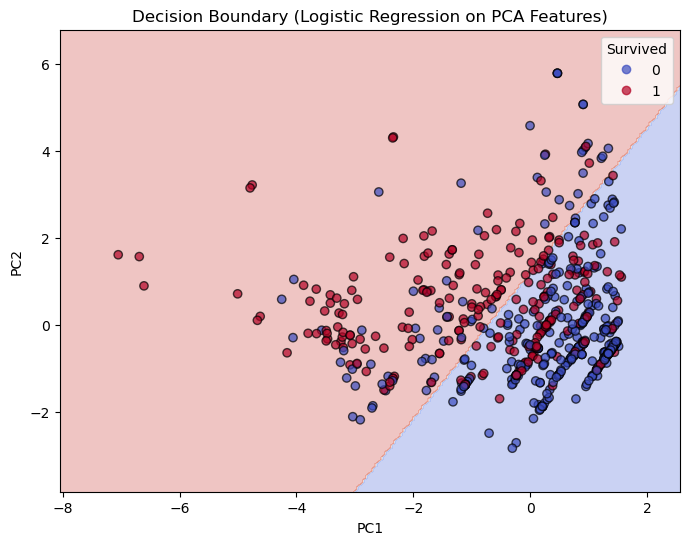

In [210]:
# 9d) Decision boundary plot using first 2 PCA components
# For decision boundary visualization, use only first 2 components
n_components_vis = 2
X_train_pca2, components2, eigenvalues2 = pca(X_train_std, n_components_vis)
X_test_pca2 = X_test_std @ components2

w_vis, b_vis, cost_history_vis = gradient_descent(
    X_train_pca2, y_train, lr=learning_rate, num_iters=optimal_iters, lambda_reg=lambda_reg
)

# Create a meshgrid over first two PCA features
x_min, x_max = X_train_pca2[:, 0].min() - 1, X_train_pca2[:, 0].max() + 1
y_min, y_max = X_train_pca2[:, 1].min() - 1, X_train_pca2[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = predict(grid_points, w_vis, b_vis)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
scatter = plt.scatter(
    X_train_pca2[:, 0],
    X_train_pca2[:, 1],
    c=y_train.ravel(),
    cmap="coolwarm",
    edgecolor="k",
    alpha=0.7
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Decision Boundary (Logistic Regression on PCA Features)")
plt.legend(*scatter.legend_elements(), title="Survived")
plt.show()